In [1]:
import torch
import matplotlib.pyplot as plt

from torch import nn
# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

Important modules:
- torchvision: Contains datasets, model architectures and image transformations often used for computer vision problems.
- torchvision.datasets: Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more.
- torchvision.models: This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems.
- torchvision.transforms: Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here.


In [2]:
def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'

device = get_device()

# Goal
Classify FashionMNIST clothings

# Data

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="datasets", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="datasets",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

### Image Info

In [4]:
print(f"Training Image length: {len(train_data.data)}")
print(f"Training Label length: {len(train_data.targets)}")
print(f"Test Image length: {len(test_data.data)}")
print(f"Test Label length: {len(test_data.targets)}")

print(f"Image shape: {train_data.data.shape}")
print(f"Classes: {train_data.classes}")

Training Image length: 60000
Training Label length: 60000
Test Image length: 10000
Test Label length: 10000
Image shape: torch.Size([60000, 28, 28])
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Plotting image

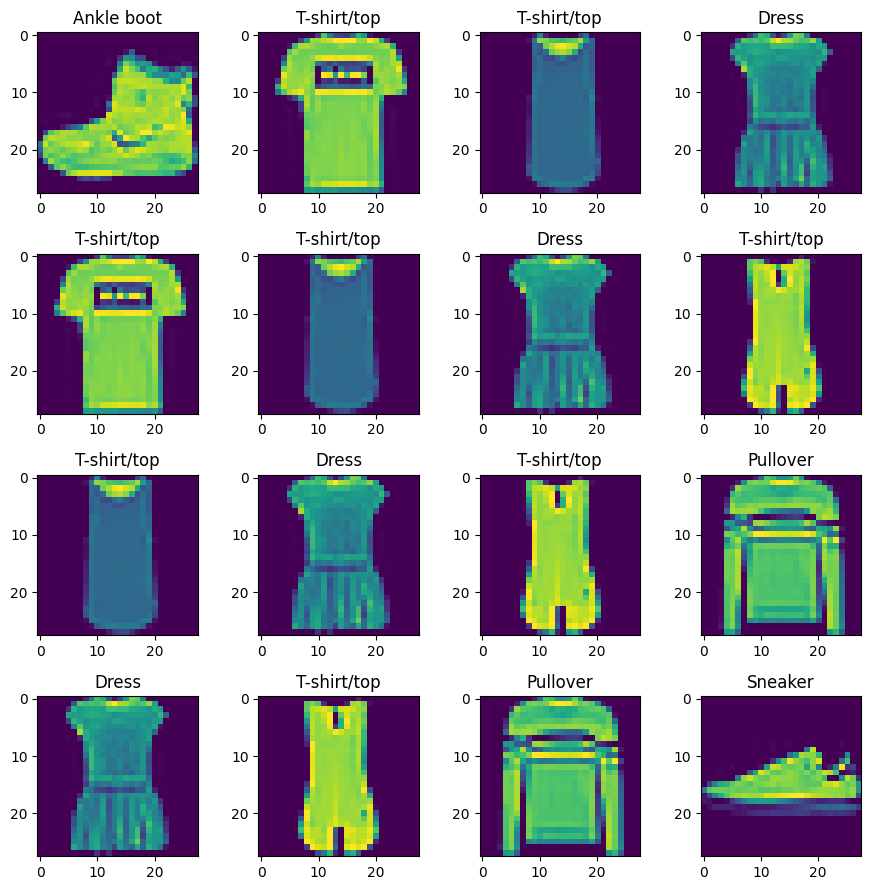

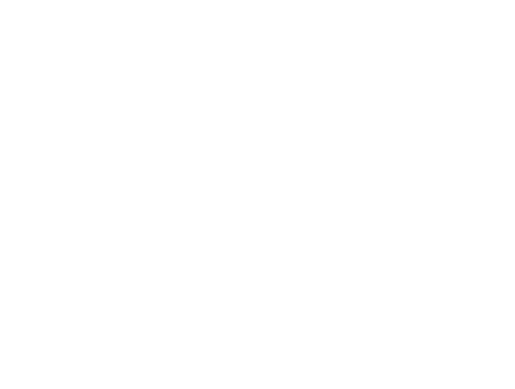

In [5]:
def plot_images(images, labels, classes):
    fig, axs = plt.subplots(4, 4, figsize=(9, 9))

    for i in range(4):
        for j in range(4):
            axs[i][j].imshow(images[i+j])
            axs[i][j].set_title(classes[labels[i+j]])
    
    plt.tight_layout()
    plt.show()
    plt.axis(False)

plot_images(train_data.data[:16], train_data.targets[:16], train_data.classes)

# Training Utility Functions

### Loading Dataloader

In [6]:
# training_data = train_data.data.type(torch.float32).to(device)
# training_targets = train_data.targets.type(torch.float32).to(device)

# testing_data = test_data.data.type(torch.float32).to(device)
# testing_targets = test_data.targets.type(torch.float32).to(device)

BATCH_SIZE=32
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f'Total training batches: {len(train_dataloader)} of size {BATCH_SIZE}')
print(f'Total testing batches: {len(test_dataloader)} of size {BATCH_SIZE}')

Total training batches: 1875 of size 32
Total testing batches: 313 of size 32


In [7]:
iter_train_data = iter(train_dataloader)

In [8]:
next_batch = next(iter_train_data)
print(f'data: {next_batch[0].shape} | label: {next_batch[1].shape}')


data: torch.Size([32, 1, 28, 28]) | label: torch.Size([32])


### Loading Model

In [9]:
def get_accuracy(prediction, actual):
    correct = torch.eq(prediction, actual).sum().item()
    return correct/len(actual)

In [10]:
def train_model(model, loss_fn, optimizer, n_epochs, device, train_dataloader, test_dataloader):
    for i in range(n_epochs):
        for batch, (X,y) in enumerate(train_dataloader):
            model.train()
            optimizer.zero_grad()
        
            output = model(X.to(device))
            loss = loss_fn(output, y.to(device))
            loss.backward()
        
            optimizer.step()
        
        if (i + 1) % 2 == 0:
            model.eval()
            cumulative_test_loss = 0
            cumulative_accuracy = 0
            
            with torch.inference_mode():
                for batch, (X,y) in enumerate(test_dataloader):
                    test_out = model(X.to(device))
                    test_loss = loss_fn(test_out, y.to(device))
    
                    cumulative_test_loss += test_loss
                    
                    test_pred = torch.argmax(test_out, dim=1)
                    accuracy = get_accuracy(test_pred.to(device), y.to(device))
                    
                    
                cumulative_test_loss /= len(test_dataloader)
            print(f'Epoch [{i+1}/{n_epochs}], Training Loss: {loss.item():.4f} | Test Loss: {cumulative_test_loss.item():.4f} | Accuracy: {accuracy}')

In [11]:
def make_predictions(model, test_dataloader):
    model.eval()
    with torch.inference_mode():
        x_test, _ = next(iter(test_dataloader))
        pred = model(x_test.to(device))
    
    pred_class = torch.argmax(pred, dim=1)
    
    x_squeezed = x_test.squeeze(dim=1)
    plot_images(x_squeezed.cpu(), pred_class.type(torch.int32).cpu(), train_data.classes)

# Model-1: Linear DNN

In [12]:
class DNN(nn.Module):
    def __init__(self, num_hidden_layers):
        super().__init__()

        self.num_hidden_layers = num_hidden_layers
        self.l_initial = nn.Linear(in_features=28*28, out_features=512)
        self.a_initial = nn.ReLU()

        for i in range(num_hidden_layers):
            setattr(self, f"l_{i}", nn.Linear(in_features=512, out_features=512))
            setattr(self, f"a_{i}", nn.ReLU())
            setattr(self, f"d_{i}", nn.Dropout(0.2))

        self.output = nn.Linear(in_features=512, out_features=9)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x_1 = x.reshape(shape=(x.size(0), -1))
        
        x_1 = self.a_initial(self.l_initial(x_1))
        for i in range(self.num_hidden_layers):
            x_1 = getattr(self, f"l_{i}")(x_1)
            x_1 = getattr(self, f"a_{i}")(x_1)
            # x_1 = getattr(self, f"d_{i}")(x_1)

        x_1 = self.output(x_1)

        # x_1 = self.softmax(x_1)

        return x_1  

In [13]:
model = DNN(1).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [14]:
train_model(model, loss_fn, optimizer, 20, device, train_dataloader, test_dataloader)

Epoch [2/20], Training Loss: 0.3158 | Test Loss: 0.4835 | Accuracy: 0.75
Epoch [4/20], Training Loss: 0.2634 | Test Loss: 0.4443 | Accuracy: 0.75
Epoch [6/20], Training Loss: 0.4405 | Test Loss: 0.3987 | Accuracy: 0.75
Epoch [8/20], Training Loss: 0.3769 | Test Loss: 0.3821 | Accuracy: 0.8125
Epoch [10/20], Training Loss: 0.3181 | Test Loss: 0.3814 | Accuracy: 0.75
Epoch [12/20], Training Loss: 0.4479 | Test Loss: 0.3562 | Accuracy: 0.8125
Epoch [14/20], Training Loss: 0.2063 | Test Loss: 0.3446 | Accuracy: 0.8125
Epoch [16/20], Training Loss: 0.1693 | Test Loss: 0.3310 | Accuracy: 0.8125
Epoch [18/20], Training Loss: 0.2194 | Test Loss: 0.3391 | Accuracy: 0.8125
Epoch [20/20], Training Loss: 0.2942 | Test Loss: 0.3291 | Accuracy: 0.8125


### Predictions

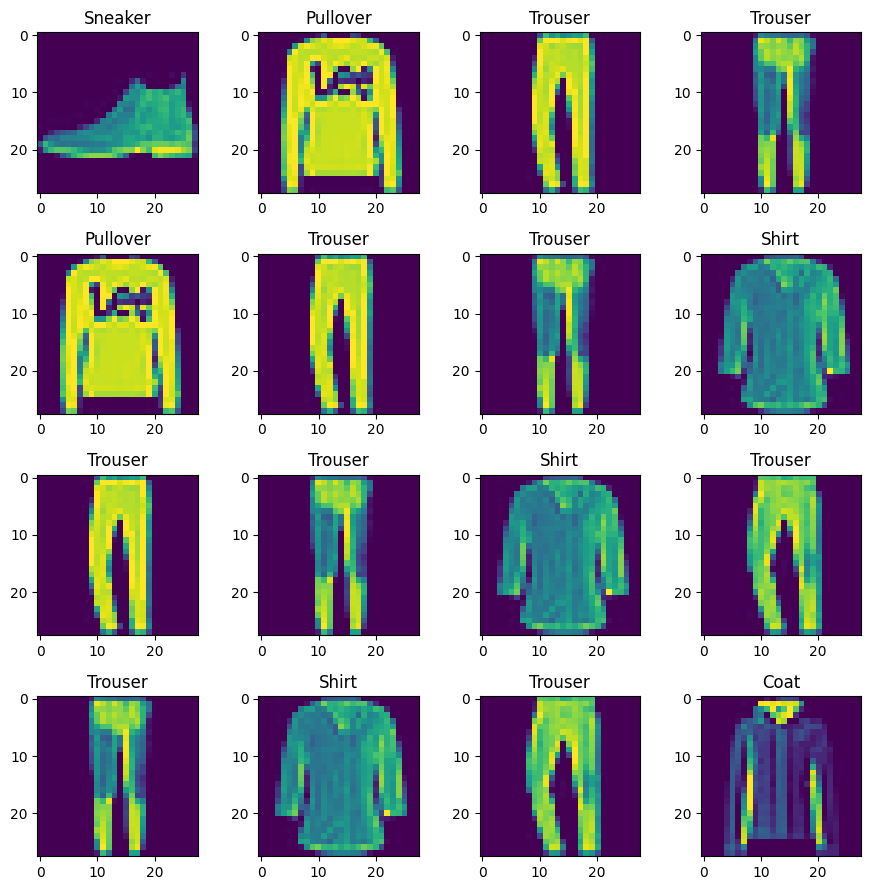

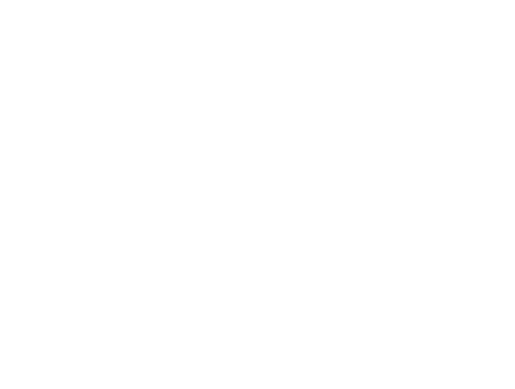

In [15]:
make_predictions(model, test_dataloader)

# Model-2: CNN

In [16]:
class CNN(nn.Module):
    def __init__(self, channel_depth, input_channels, output_classes):
        super().__init__()
        # 28*28 -> channel_depth*12*12
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel_depth, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # channel_depth*12*12 -> channel_depth*4*4
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=channel_depth, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel_depth, 
                      out_channels=channel_depth, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=channel_depth*4*4, 
                out_features=output_classes
            )
        )

    def forward(self, x):
        x_1 = self.block1(x)
        x_1 = self.block2(x_1)
        return self.classifier(x_1)        

#### Conv2d
The 2d is for 2-dimensional data. As in, our images have two dimensions: height and width. Yes, there's color channel dimension but each of the color channel dimensions have two dimensions too: height and width.

For other dimensional data (such as 1D for text or 3D for 3D objects) there's also nn.Conv1d() and nn.Conv3d().

#### MaxPool2d
Essentially, every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being smaller in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to compress information.

In [17]:
cnn_model = CNN(30, input_channels=1, output_classes=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01)

In [18]:
train_model(cnn_model, loss_fn, optimizer, 20, device, train_dataloader, test_dataloader)

Epoch [2/20], Training Loss: 0.2786 | Test Loss: 0.4908 | Accuracy: 0.875
Epoch [4/20], Training Loss: 0.2225 | Test Loss: 0.4161 | Accuracy: 0.875
Epoch [6/20], Training Loss: 0.2187 | Test Loss: 0.3725 | Accuracy: 0.9375
Epoch [8/20], Training Loss: 0.2911 | Test Loss: 0.3490 | Accuracy: 0.9375
Epoch [10/20], Training Loss: 0.3586 | Test Loss: 0.3322 | Accuracy: 0.9375
Epoch [12/20], Training Loss: 0.2501 | Test Loss: 0.3148 | Accuracy: 1.0
Epoch [14/20], Training Loss: 0.1929 | Test Loss: 0.3058 | Accuracy: 1.0
Epoch [16/20], Training Loss: 0.3354 | Test Loss: 0.3030 | Accuracy: 1.0
Epoch [18/20], Training Loss: 0.2999 | Test Loss: 0.2974 | Accuracy: 1.0
Epoch [20/20], Training Loss: 0.3957 | Test Loss: 0.2961 | Accuracy: 1.0


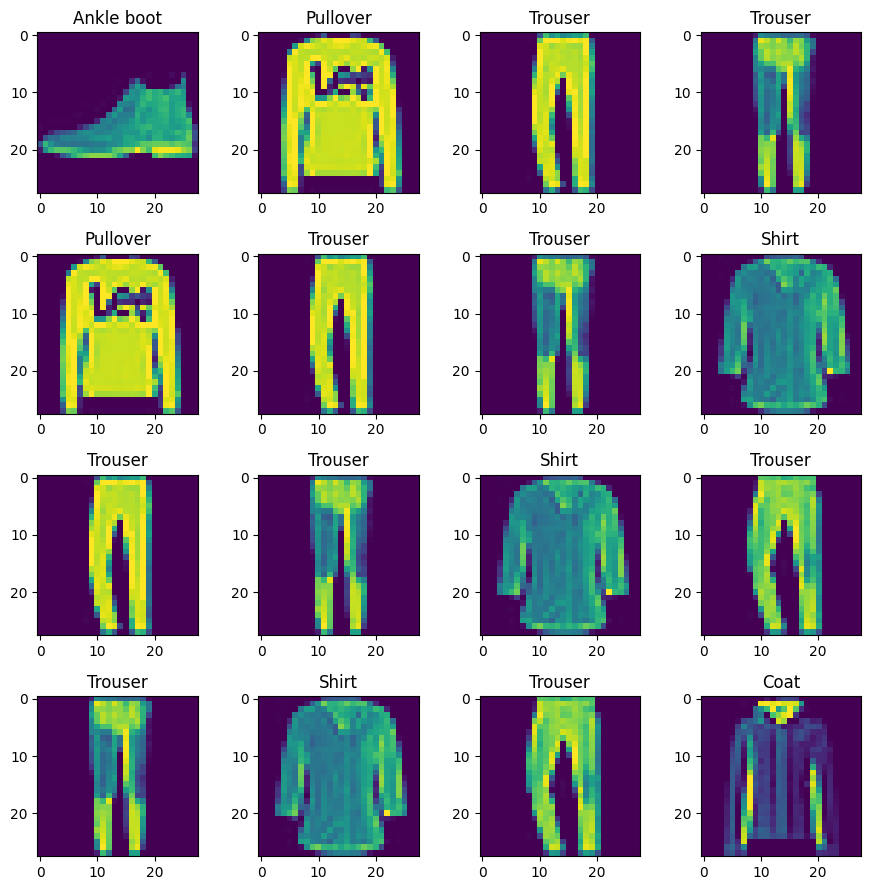

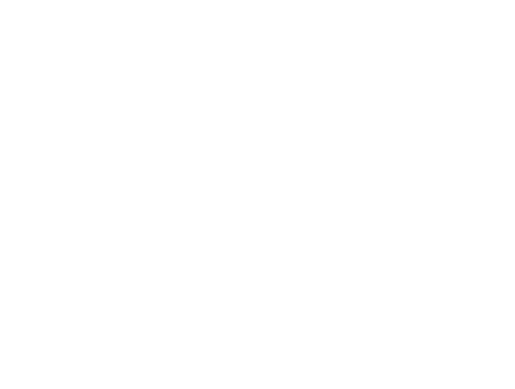

In [19]:
make_predictions(cnn_model, test_dataloader)